# Inspect images for poorly predicted ldh samples

In [1]:
import polars as pl
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests

In [2]:
preds = pl.read_parquet("../1_snakemake/outputs/cellprofiler/mad_featselect/classifier_results/predictions_continuous.parquet")
meta = pl.read_parquet("../1_snakemake/inputs/metadata/metadata.parquet").drop(["Metadata_Compound", "Metadata_Log10Conc"])
preds = preds.join(meta, on=["Metadata_Plate", "Metadata_Well"])

In [3]:
preds = preds.with_columns(
    pl.when(pl.col("Metadata_Compound") == "DMSO").then(pl.lit("DMSO")).otherwise(pl.lit("Compound")).alias("Well_type")
)

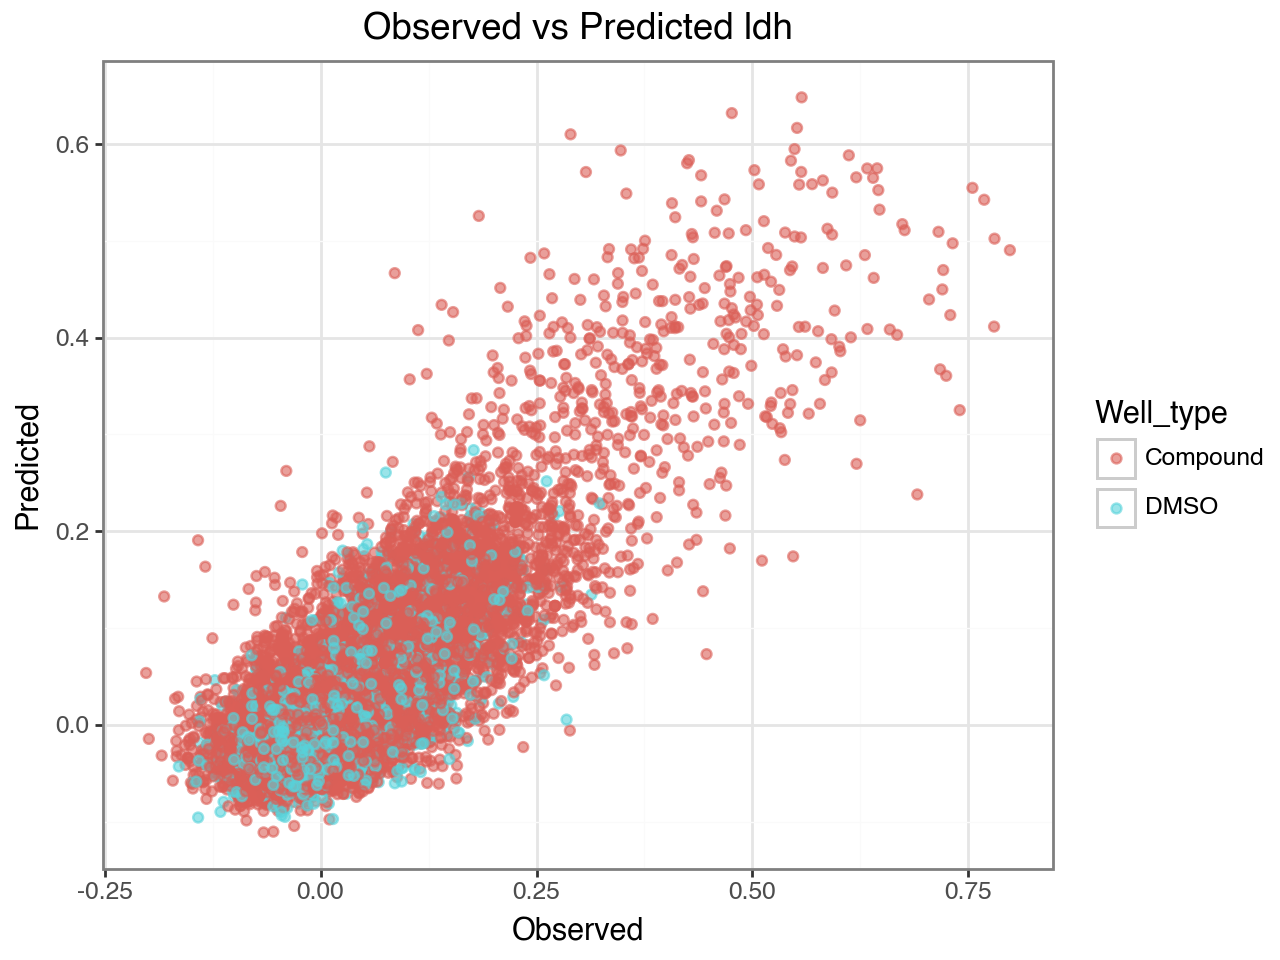

In [4]:
from plotnine import aes, geom_point, ggplot, labs, theme_bw, geom_histogram
import plotnine as pn

plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_ldh_normalized"), aes(x="Observed", y="Predicted", color="Well_type"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted ldh",
    )
    + theme_bw()
)

plot1.show()

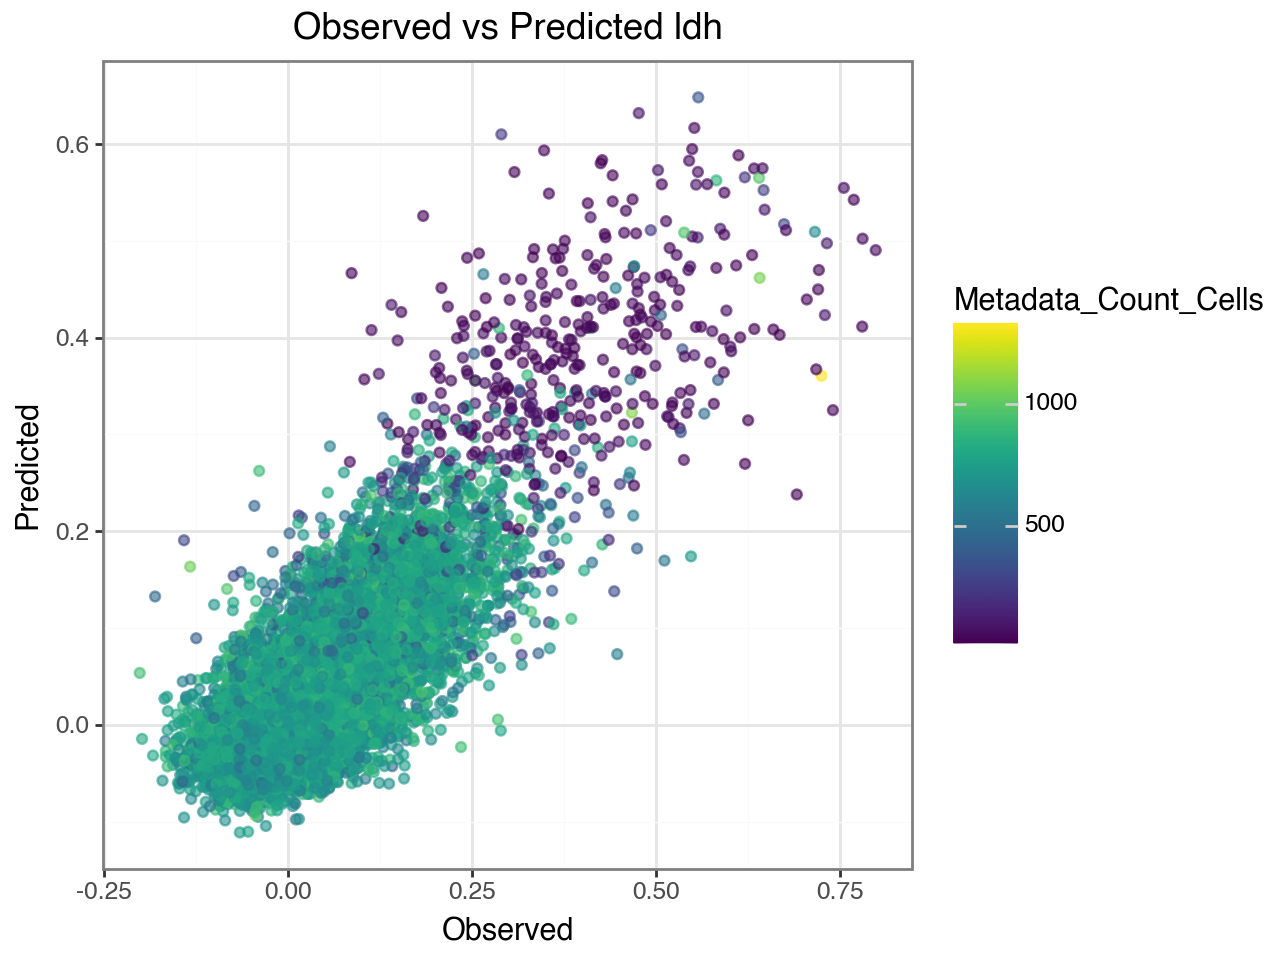

In [5]:
plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_ldh_normalized"), aes(x="Observed", y="Predicted", color="Metadata_Count_Cells"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted ldh",
    )
    + theme_bw()
)

plot1.show()

In [6]:
# Get residuals of the 1:1 line
ldh = preds.filter(pl.col("Variable_Name") == "Metadata_ldh_normalized")

ldh = ldh.with_columns(
    (pl.col("Predicted") - pl.col("Observed")).alias("Diff_pred_obs")
)

/Users/jewald/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 184'. Pick better value with 'binwidth'.


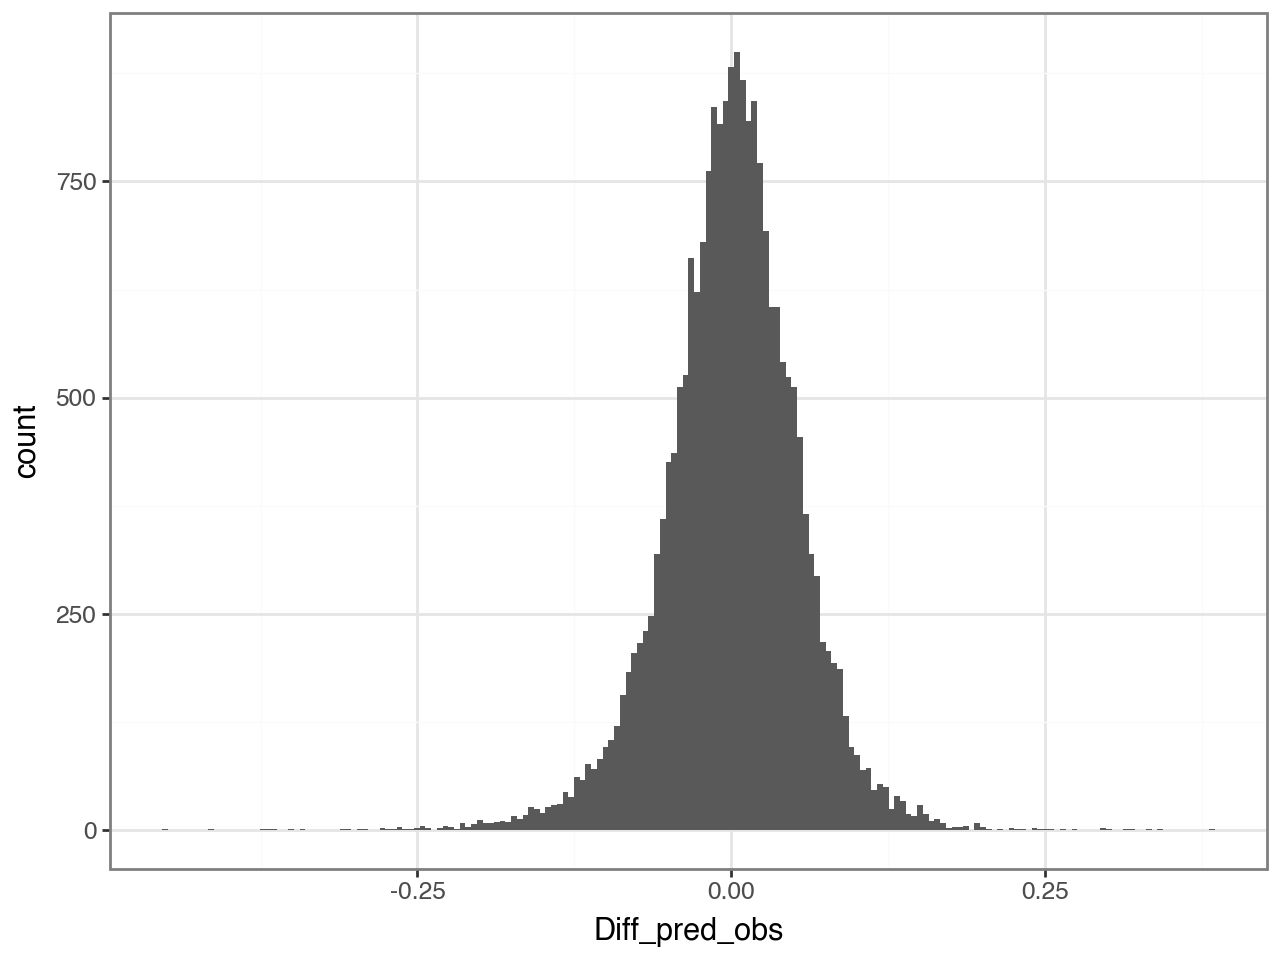

In [7]:
plot1 = (
    ggplot(ldh, aes(x="Diff_pred_obs"))
    + geom_histogram()
    + labs(
        x="Diff_pred_obs",
    )
    + theme_bw()
)

plot1.show()

In [8]:
print(ldh.shape)
print(ldh.filter(pl.col("Diff_pred_obs") > 0).shape)
print(ldh.filter(pl.col("Diff_pred_obs") < 0).shape)

std = ldh.select(pl.col("Diff_pred_obs").std()).to_numpy()[0][0]

thresh = std*2.58 # 2.58 std = p-val 0.01

ldh = ldh.with_columns(
    pl.when(pl.col("Diff_pred_obs") > thresh)
      .then(pl.lit("Higher"))
      .when(pl.col("Diff_pred_obs") < (-1*thresh))
      .then(pl.lit("Lower"))
      .otherwise(pl.lit("Normal")).alias("Outlier_flag"),
    pl.concat_str(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID"),
)

(21807, 29)
(11235, 29)
(10572, 29)


In [9]:
ldh.select(pl.col("Outlier_flag").value_counts()).unnest("Outlier_flag")

Outlier_flag,counts
str,u32
"""Normal""",21366
"""Lower""",285
"""Higher""",156


In [11]:
# Get target set library
targets = pl.read_parquet("../1_snakemake/inputs/annotations/cg_motive.parquet")
targets = targets.select(["target", "interaction_type", "OASIS_ID"]).unique().with_columns(
    pl.concat_str(["target", "interaction_type"], separator="_").alias("target_set")
)

target_set_size = targets.select(pl.col("target_set").value_counts()).unnest("target_set").filter(pl.col("counts") >= 3)
keep_sets = target_set_size.select("target_set").to_series().to_list()
targets = targets.filter(pl.col("target_set").is_in(keep_sets))

In [12]:

cmpd_meta = meta.select(["Metadata_OASIS_ID", "Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"]).with_columns(
    pl.concat_str(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID")
).drop(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"]).rename({"Metadata_OASIS_ID": "OASIS_ID"})

targets = targets.join(cmpd_meta, on="OASIS_ID").select(["target_set", "Unique_ID"]).unique()

In [13]:
import polars as pl
from scipy.stats import hypergeom

def overrepresentation_analysis(target_set_library: pl.DataFrame, target_hits: list, universe: list):
    target_hits_set = set(target_hits)
    universe_set = set(universe)

    sets = target_set_library.select(pl.col("target_set")).unique().to_series()
    
    # Initialize results list
    results = []

    # For each target set, calculate the overlap and perform the hypergeometric test
    for target_set in tqdm(sets):
        targets_in_set = set(target_set_library.filter(pl.col("target_set") == target_set)["Unique_ID"].to_list())
        
        # Intersection between gene hits and the current gene set
        overlap = target_hits_set.intersection(targets_in_set)
        overlap_size = len(overlap)

        # Calculate hypergeometric test parameters
        M = len(universe_set)  # Total number of genes in the universe
        n = len(targets_in_set)  # Number of genes in the gene set
        N = len(target_hits_set)  # Number of gene hits
        x = overlap_size  # Number of overlapping genes (successes)

        # Perform the hypergeometric test
        p_value = hypergeom.sf(x - 1, M, n, N)  # Survival function for right-tailed test

        # Store the result
        results.append({
            "target_set": target_set,
            "overlap_size": overlap_size,
            "target_set_size": n,
            "hit_list_size": N,
            "universe_size": M,
            "p_value": p_value,
        })

    # Return the results as a Polars DataFrame
    return pl.DataFrame(results)


In [14]:
higher_hits = ldh.filter(pl.col("Outlier_flag") == "Higher").select("Unique_ID").to_series().to_list()
lower_hits = ldh.filter(pl.col("Outlier_flag") == "Lower").select("Unique_ID").to_series().to_list()

universe = ldh.select("Unique_ID").to_series().unique().to_list()

# Perform overrepresentation analysis
higher_results = overrepresentation_analysis(targets, higher_hits, universe)
lower_results = overrepresentation_analysis(targets, lower_hits, universe)

100%|██████████| 24944/24944 [01:44<00:00, 238.38it/s]


In [15]:
# FDR adjust the p-values
def fdr_polars(df: pl.DataFrame):
    p_values = df.select("p_value").to_series().to_numpy()
    _, p_adjusted, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    df = df.with_columns(pl.Series("fdr", p_adjusted))
    return df

In [16]:
higher_results = fdr_polars(higher_results)
lower_results = fdr_polars(lower_results)

## Interactive plots

In [17]:
import plotly.express as px

filtered_preds = preds.filter(pl.col("Variable_Name") == "Metadata_ldh_normalized").to_pandas()

fig = px.scatter(
    filtered_preds,
    x="Observed",
    y="Predicted",
    title="Observed vs Predicted ldh",
    labels={"Observed": "Observed", "Predicted": "Predicted"},
    hover_data=["Metadata_Plate", "Metadata_Well"]
)

fig.show()